In [344]:
# библиотеки
import random
import time

import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pylab import rcParams

## Обработка данных

In [345]:
# достаем названия файлов и концентрации
file_conc_name = "Cu_conc.txt"
data_y = pd.read_csv(file_conc_name, sep = ' ', header = None)
spect_names = data_y.iloc[:, 1]
data_y.head()

,0,1
0,13.85,7278_01_07_2024
1,19.23,7282_01_07_2024
2,18.54,7296_02_07_2024
3,19.60,7310_03_07_2024
4,16.48,7311_03_07_2024


In [346]:
# создаем словарь для спектра
def init_spectrum():
    file_name = "elements_windows.txt"
    f = open(file_name, 'r')
    s = f.readline().rstrip('\n').split()
    spectrum = dict()
    while s:
        spectrum[s[0]] = np.array([s[1], s[2], 0], dtype = 'float64')
        s = f.readline().rstrip('\n').split()
    f.close()
    return spectrum

spectrum = init_spectrum()

In [347]:
# читаем все файлики в большой массив
data = []
folder_name = "spectrums2"
for k in spect_names:
    file_name = folder_name + "/" + k + ".mca"
    f = open(file_name, "r", encoding="utf8")
    s = f.readline().rstrip('\n')
    data_temp = []
    while s:
        if s.split()[0] == "LIVE_TIME":
            time = float(s.split()[2])
        if s.isdigit():
            data_temp.append(float(s))
        s = f.readline().rstrip('\n')
    f.close()
    data.append(np.array(data_temp.copy())/time)

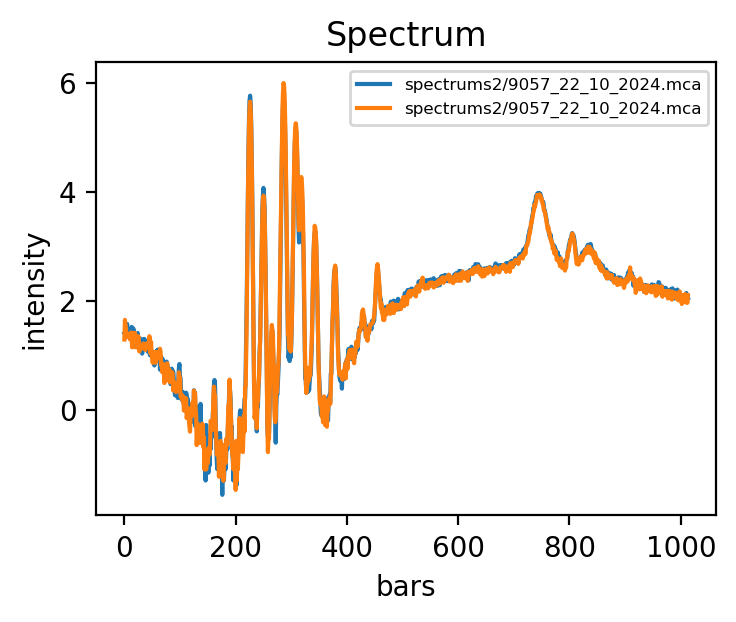

In [348]:
fig = plt.figure(figsize =(4, 3))   
fig.set_dpi(200) 

# график в логарифмических координатах
for i in range(2):
    data_temp = np.array(data[i].copy())
    data_temp = data_temp[data_temp > 0]
    X = range(len(data_temp))
    plt.plot(X, np.log(data_temp), label = file_name)

#plt.xlim(304, 311)
#plt.ylim(0, 200)
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300
plt.title(f"Spectrum")
plt.legend(fontsize = 6.0)
plt.xlabel("bars")
plt.ylabel("intensity")
plt.savefig("spectr_log")
plt.show()
plt.close()

In [349]:
# создаем dataframe с данными
data_x = pd.DataFrame()
for k in range(len(spect_names)):
    data_temp = data[k].copy()
    spectrum = init_spectrum()
    # интенсивности для каждого файла
    for i in spectrum:
        l = int(spectrum[i][0])
        r = int(spectrum[i][1] + 1)
        for j in range(l, r):
            spectrum[i][2] += data_temp[j]
        # убираем фон, или нет...
        offset = 0
        fon = 1/2*(data_temp[r+offset] + data_temp[l-offset])*(r-l+2*offset)
        spectrum[i][2] -= fon
    
    temp_x = pd.Series(data=np.array(list(spectrum.values()))[:, 2], index=list(spectrum.keys()))
    data_x = pd.concat([data_x, temp_x.to_frame().T])

data_x.head()

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,5.393287e-01,2.495717,3.288848,1640.109135,313.191345,-0.867156,2.072714,15.841459,-25.401324,1604.682642,103.572259,821.513927,134.303420,86.356042,50.009518,4.970284,809.965948,101.288044
0,-1.776357e-15,1.935905,3.156366,1442.417356,285.146140,-0.441891,3.398354,18.033373,-28.260000,2065.000105,119.058140,881.341666,143.456852,80.403173,62.811691,3.829725,823.769543,88.378259
0,-1.976834e+00,3.643785,2.991964,1266.690887,240.703539,-0.406052,1.528039,20.131646,-21.050607,1765.088049,104.056249,694.221234,120.779193,69.563173,44.676440,3.398017,938.066336,112.914601
0,1.601161e+00,3.415811,3.330416,1279.327939,244.209133,0.747209,-0.010674,16.790846,-23.120770,1825.494759,112.145343,863.847911,140.859503,91.202152,69.063427,1.814650,920.774535,106.765441
0,5.831337e-01,1.993257,2.640005,1451.939184,279.925359,-0.487712,1.176870,17.536419,-30.980301,1664.093810,100.871520,907.833075,156.661507,90.841621,75.351471,3.244344,882.376641,105.960686


In [350]:
# нормируем от 0 до 1
data_norm_x = data_x.to_numpy()
min_x = data_norm_x.min()
wide_x = data_norm_x.max() - data_norm_x.min()
# print(min_x)
# print(wide_x)
data_x_norm = (data_x - min_x)/wide_x
data_x_norm.index = spect_names
data_x_norm.head()

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
1,,,,,,,,,,,,,,,,,,
7278_01_07_2024,0.015431,0.015927,0.016129,0.431577,0.094786,0.015074,0.015820,0.019315,0.008847,0.422586,0.041582,0.223806,0.049382,0.037212,0.027987,0.016555,0.220875,0.041002
7282_01_07_2024,0.015294,0.015785,0.016095,0.381400,0.087668,0.015182,0.016156,0.019871,0.008121,0.539421,0.045512,0.238991,0.051705,0.035701,0.031236,0.016266,0.224378,0.037725
7296_02_07_2024,0.014792,0.016219,0.016053,0.336798,0.076388,0.015191,0.015682,0.020403,0.009951,0.463299,0.041705,0.191497,0.045949,0.032950,0.026633,0.016156,0.253389,0.043953
7310_03_07_2024,0.015700,0.016161,0.016139,0.340006,0.077278,0.015483,0.015291,0.019556,0.009425,0.478631,0.043758,0.234551,0.051046,0.038442,0.032823,0.015754,0.249000,0.042392
7311_03_07_2024,0.015442,0.015800,0.015964,0.383817,0.086343,0.015170,0.015592,0.019745,0.007431,0.437665,0.040896,0.245715,0.055057,0.038351,0.034419,0.016117,0.239254,0.042188


In [351]:
# нормируем Y от 0 до 1
data_norm_y = data_y.iloc[:, 0].to_numpy()
min_y = data_norm_y.min()
wide_y = data_norm_y.max() - data_norm_y.min()
# print("min_y ", min_y)
# print("wide_y ", wide_y)
data_y_norm = (data_norm_y - min_y)/wide_y
data_y_norm

array([0.14878622, 0.57008614, 0.51605325, 0.5990603 , 0.35473767,
       0.39624119, 0.37823023, 0.3422083 , 0.3101018 , 0.33516053,
       0.47454973, 0.26389977, 0.38449491, 0.31793265, 0.70790916,
       0.21613156, 0.51292091, 0.19420517, 0.38841034, 0.56617071,
       0.49021143, 0.06186374, 0.28974158, 0.1816758 , 0.36805012,
       0.45105717, 0.        , 0.3797964 , 0.41033673, 0.24823806,
       0.23101018, 0.24197338, 0.38449491, 0.2247455 , 0.45497259,
       0.20516836, 0.46750196, 0.32811276, 0.3688332 , 0.57870008,
       0.39154268, 0.51996868, 0.52545027, 0.41973375, 0.39467502,
       0.30696946, 0.94048551, 0.91072827, 0.79483164, 0.28660924,
       0.57635082, 0.20751762, 1.        , 0.64056382])

In [352]:
# сводная табличка с отнормарованными данными
data_xy = data_x_norm.copy()
data_y.index = spect_names
data_xy.index = spect_names
data_xy["Cu_conc"] = data_y_norm
data_xy.head()

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr,Cu_conc
1,,,,,,,,,,,,,,,,,,,
7278_01_07_2024,0.015431,0.015927,0.016129,0.431577,0.094786,0.015074,0.015820,0.019315,0.008847,0.422586,0.041582,0.223806,0.049382,0.037212,0.027987,0.016555,0.220875,0.041002,0.148786
7282_01_07_2024,0.015294,0.015785,0.016095,0.381400,0.087668,0.015182,0.016156,0.019871,0.008121,0.539421,0.045512,0.238991,0.051705,0.035701,0.031236,0.016266,0.224378,0.037725,0.570086
7296_02_07_2024,0.014792,0.016219,0.016053,0.336798,0.076388,0.015191,0.015682,0.020403,0.009951,0.463299,0.041705,0.191497,0.045949,0.032950,0.026633,0.016156,0.253389,0.043953,0.516053
7310_03_07_2024,0.015700,0.016161,0.016139,0.340006,0.077278,0.015483,0.015291,0.019556,0.009425,0.478631,0.043758,0.234551,0.051046,0.038442,0.032823,0.015754,0.249000,0.042392,0.599060
7311_03_07_2024,0.015442,0.015800,0.015964,0.383817,0.086343,0.015170,0.015592,0.019745,0.007431,0.437665,0.040896,0.245715,0.055057,0.038351,0.034419,0.016117,0.239254,0.042188,0.354738


In [400]:
# выбираем dim_x наиболее значимых компонентов
dim_x = 5
elem_names = ['Fe_Ka', 'Zn_Ka', 'Cu_Ka', 'Pb_Lb', 'Nkr']
# final_data = data_x_norm[data_x_norm.sum().sort_values(ascending=False)[:dim_x].index].copy()
# final_data = data_x_norm.copy()
final_data = data_x_norm[elem_names].copy()
final_data.head()

,Fe_Ka,Zn_Ka,Cu_Ka,Pb_Lb,Nkr
1,,,,,
7278_01_07_2024,0.431577,0.223806,0.422586,0.027987,0.220875
7282_01_07_2024,0.381400,0.238991,0.539421,0.031236,0.224378
7296_02_07_2024,0.336798,0.191497,0.463299,0.026633,0.253389
7310_03_07_2024,0.340006,0.234551,0.478631,0.032823,0.249000
7311_03_07_2024,0.383817,0.245715,0.437665,0.034419,0.239254


In [401]:
data_x.corr().round(2)

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
S,1.00,0.01,-0.04,-0.05,-0.05,-0.18,-0.11,0.05,-0.03,-0.11,-0.14,0.06,0.07,0.05,0.06,-0.11,0.10,-0.04
Ag,0.01,1.00,0.07,-0.17,-0.18,-0.09,-0.10,0.12,0.14,0.04,0.06,-0.15,-0.14,-0.07,-0.11,0.03,0.14,0.14
Cr,-0.04,0.07,1.00,0.44,0.43,0.05,0.05,-0.30,0.18,-0.04,-0.07,-0.15,-0.16,-0.01,-0.18,0.34,-0.27,-0.10
Fe_Ka,-0.05,-0.17,0.44,1.00,1.00,-0.13,0.22,-0.81,-0.11,-0.18,-0.20,0.09,0.07,0.26,0.00,0.79,-0.86,-0.57
Fe_Kb,-0.05,-0.18,0.43,1.00,1.00,-0.13,0.23,-0.81,-0.11,-0.17,-0.20,0.09,0.07,0.26,0.01,0.79,-0.87,-0.57
Ar_Kb,-0.18,-0.09,0.05,-0.13,-0.13,1.00,-0.03,0.18,-0.08,0.13,0.17,0.05,0.05,-0.14,-0.12,-0.08,0.09,0.10
Ca_Ka,-0.11,-0.10,0.05,0.22,0.23,-0.03,1.00,-0.34,0.07,0.03,0.03,-0.03,-0.05,0.04,-0.11,0.28,-0.22,-0.06
Ni_Ka,0.05,0.12,-0.30,-0.81,-0.81,0.18,-0.34,1.00,0.07,-0.15,-0.15,-0.02,0.01,-0.43,-0.19,-0.57,0.85,0.46
Ni_kb,-0.03,0.14,0.18,-0.11,-0.11,-0.08,0.07,0.07,1.00,-0.30,-0.22,-0.97,-0.96,-0.04,-0.31,-0.17,0.42,0.27
Cu_Ka,-0.11,0.04,-0.04,-0.18,-0.17,0.13,0.03,-0.15,-0.30,1.00,0.98,0.19,0.15,-0.04,0.12,-0.09,-0.21,-0.10


## Создание и обучение нейронной сети

In [402]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            # print("a = ", a, '\n')
            # print("w*a = ", np.dot(w, a), '\n')
            # print("b = ", b, '\n')
            # a = self.sigmoid(np.dot(w, a).reshape(b.shape)+b)
            a = self.sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        errors = []
        for j in range(epochs):
            # print("eposh ", j)
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                pass
                #print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                errors.append(self.my_evaluate(training_data)[0])
                #print("Epoch {0} complete".format(j))
        rcParams['figure.figsize'] = 8, 6
        rcParams['figure.dpi'] = 300
        plt.plot(errors)
        plt.title("Loss")
        plt.xlabel("t")
        plt.ylabel("C")
        plt.savefig(f"Ct{eta}.png")
        plt.show()
        # plt.close()

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x] 
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            # z = np.dot(w, activation).reshape(b.shape) + b
            z = np.dot(w, activation) + b
            zs.append(z.copy())
            # print("zzz ", z)
            # print("xui ", np.dot(w, activation).reshape(b.shape))
            # print("b ", b)
            activation = self.sigmoid(z)
            activations.append(activation.copy())

        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # print("b ", self.biases)
        # print("w ", self.weights)
        # print("zzz ", zs)
        # print("a ", activations)
        # print("x ", x)
        # print("y ", y)
        # print("11 ", self.cost_derivative(activations[-1], y))
        # print("sigmoid", self.sigmoid_prime(zs[-1]))
        # print("delta = ", delta)
        # print("nabla_w ", nabla_w[-1], '\n')
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            # print("delta = ", delta)
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].reshape(1, len(activations[-l-1])))
            # print("nabla_w ", nabla_w[-l], '\n')
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)/len(test_data)
    
    def my_evaluate(self, test_data):
        
        test_results = [(self.feedforward(x), y)
                        for (x, y) in test_data]
        return sum(abs(x - y)**2 for (x, y) in test_results)/len(test_data)
    
    def r2_score(self, test_data):
        
        test_results = [(self.feedforward(x), y)
                        for (x, y) in test_data]
        y_mean = sum(y for (x, y) in test_results)/len(test_data)
        SSres = sum((x - y)**2 for (x, y) in test_results)/len(test_data)
        SStot = sum((y_mean - y)**2 for (x, y) in test_results)/len(test_data)
        R_2 = 1.0 - SSres/SStot
        return R_2

    def cost_derivative(self, output_activations, y):

        return (output_activations-y)


    def sigmoid(self,z):
        """The sigmoid function."""
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_prime(self,z):
        """Derivative of the sigmoid function."""
        return self.sigmoid(z)*(1-self.sigmoid(z))


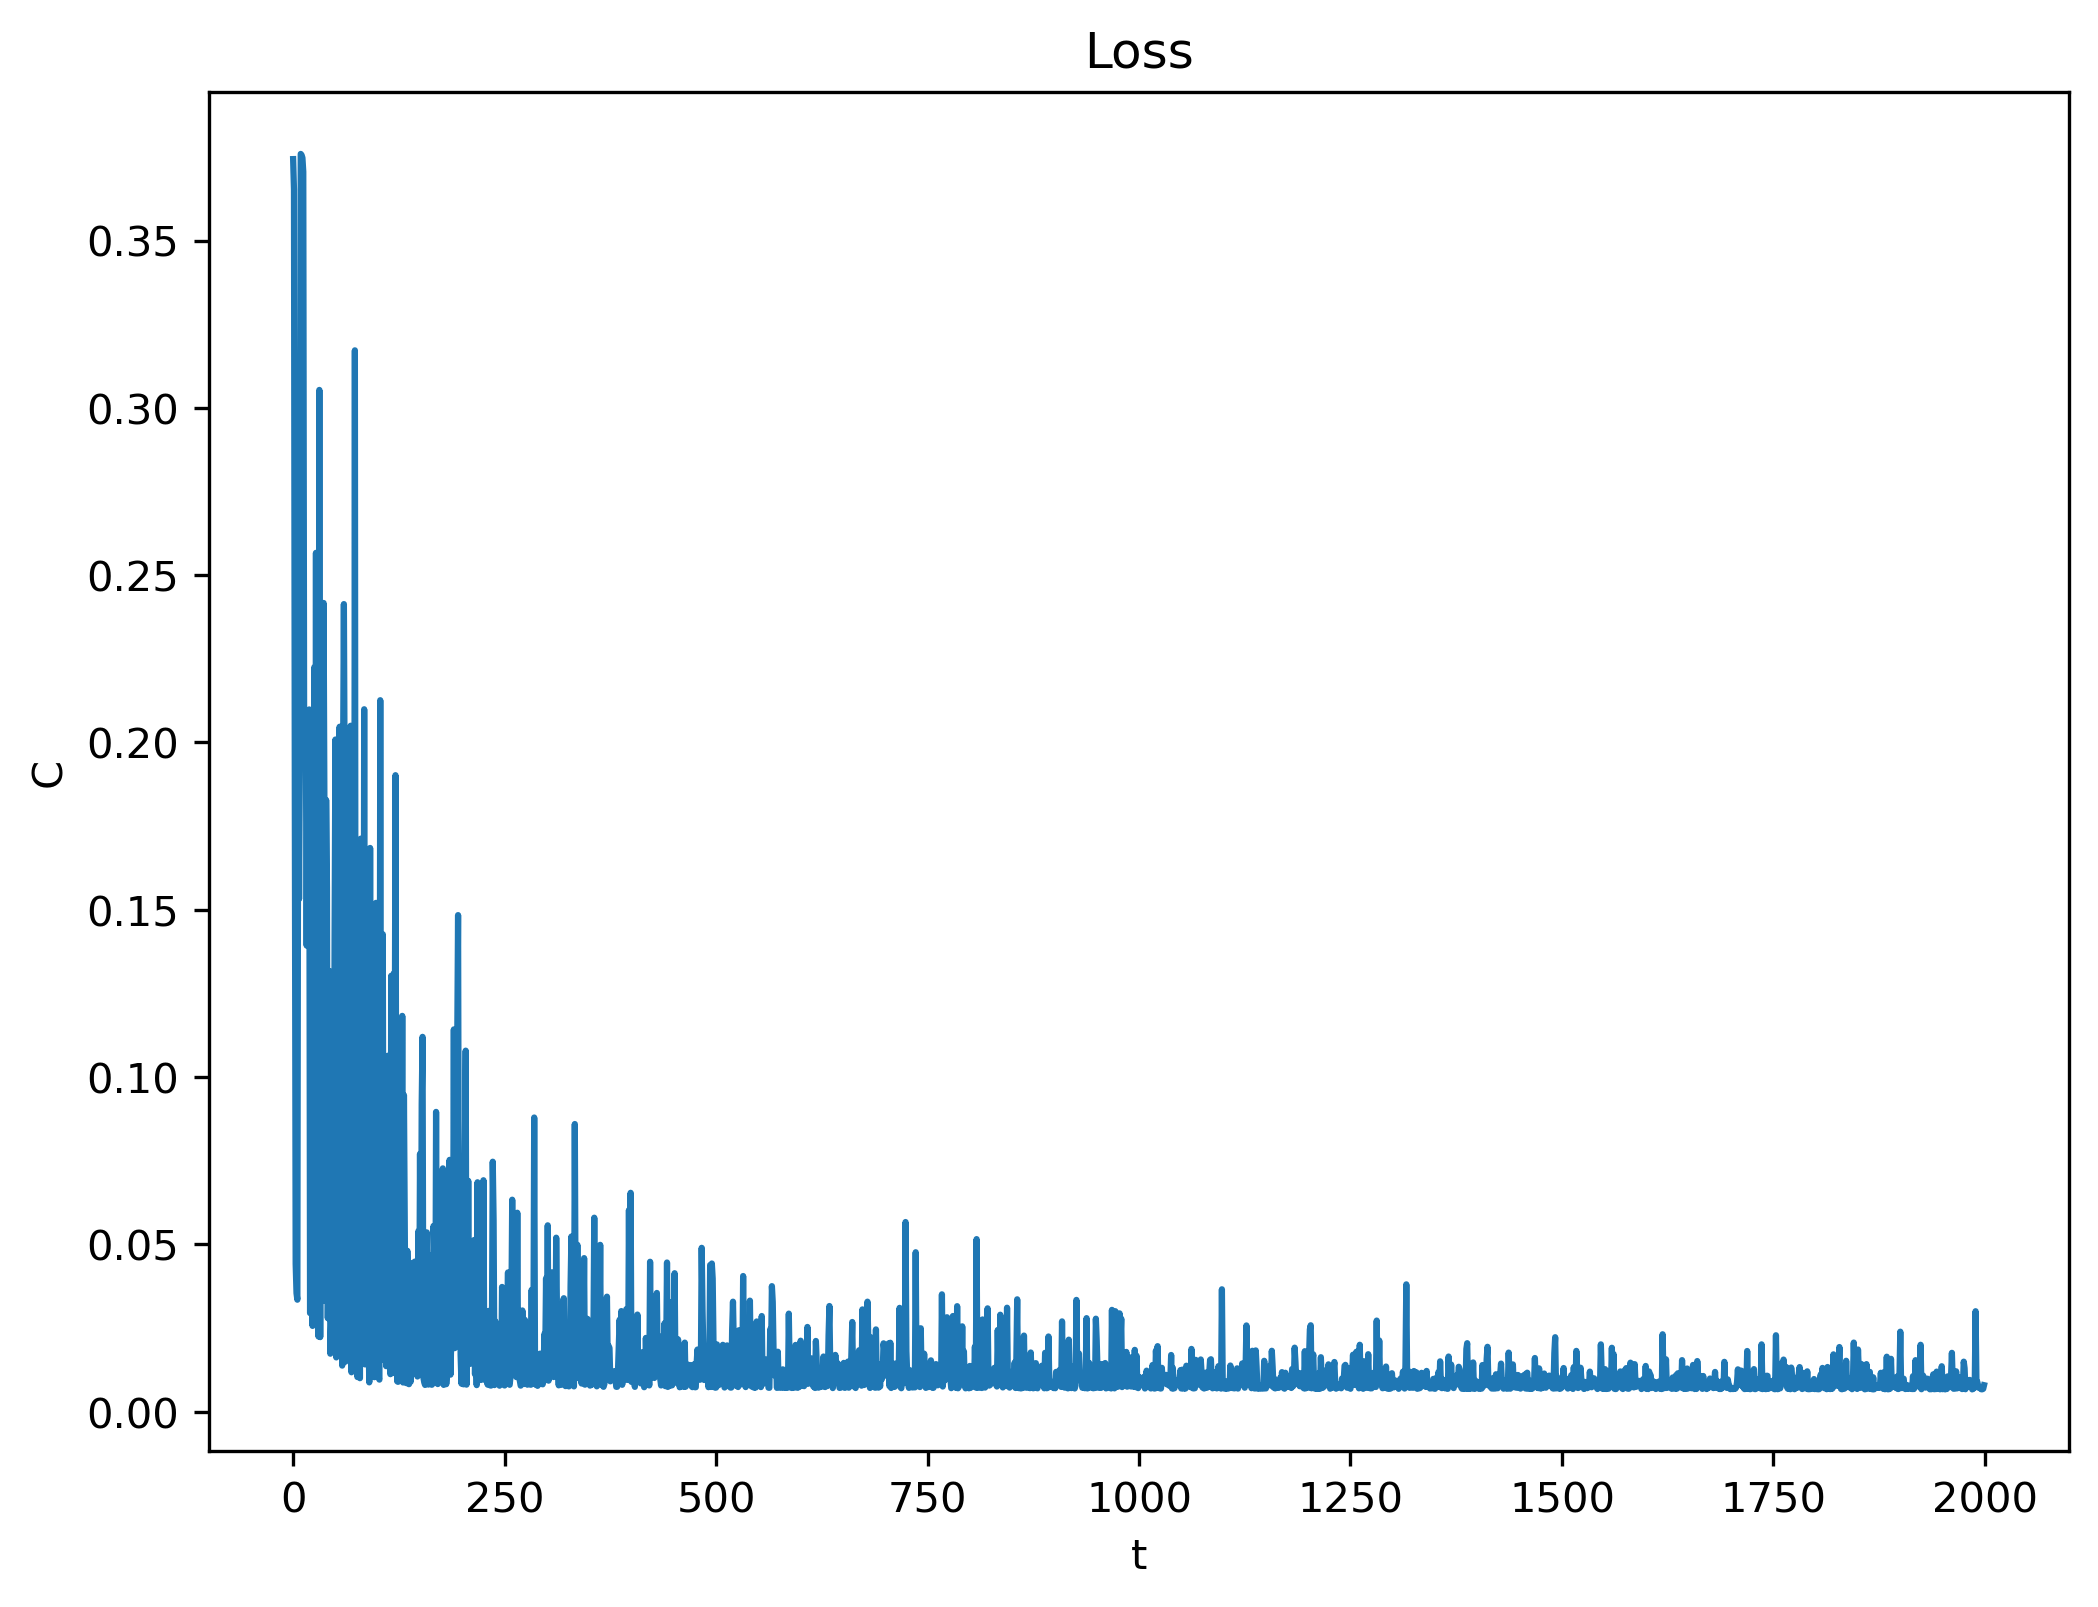

In [409]:
# разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(final_data, data_y_norm, test_size=0.2,  random_state=0)
epochs = 2000
train = []
XX = X_train.to_numpy()
for i in range(len(y_train)):
    train.append((XX[i].reshape(dim_x, 1), y_train[i]))
    
test = []
XX = X_test.to_numpy()
for i in range(len(y_test)):
    test.append([XX[i].reshape(dim_x, 1), y_test[i]])
N1 = 20*dim_x
N2 = 0 # 1*dim_x
# sizes = np.array([dim_x, N1, N2, 1])
sizes = np.array([dim_x, N1, 1])
net = Network(sizes)
net.SGD(train, epochs, mini_batch_size = 5, eta = 2)

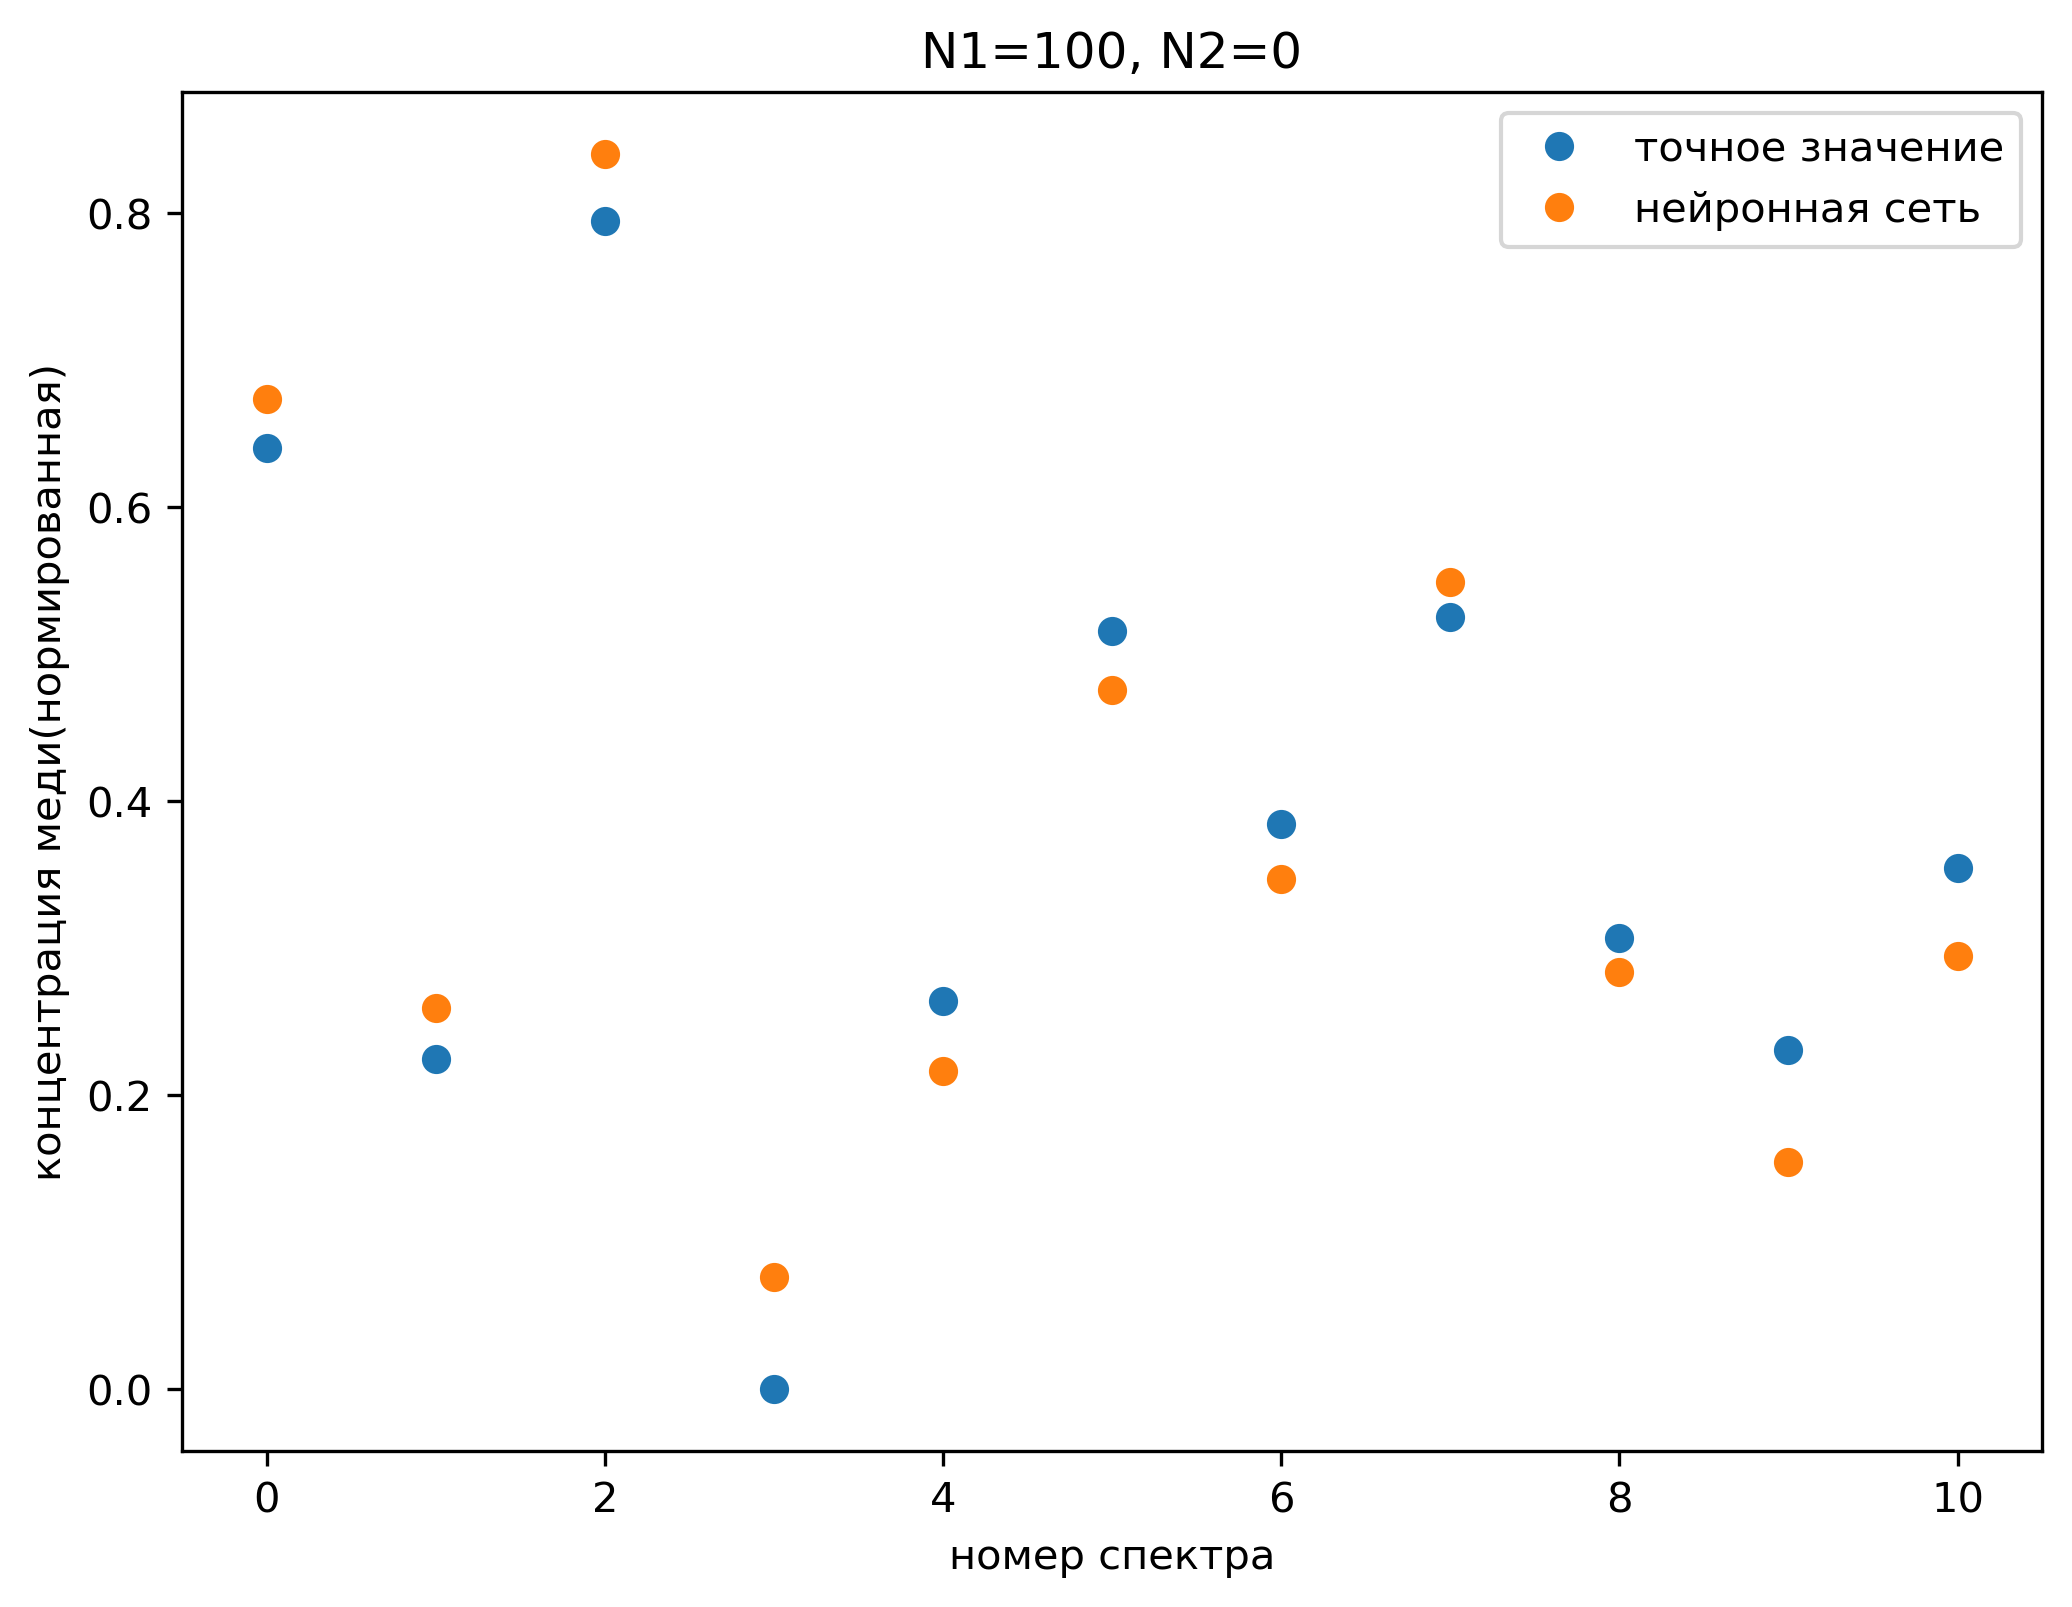

In [410]:
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300
# данные тестовой выборки и предикт
plt.plot(y_test, 'o', label="точное значение")
net.feedforward(X_test.to_numpy()[0])
result = [net.feedforward(test[i][0])[0] for i in range(len(y_test))]
plt.plot(result, 'o', label="нейронная сеть")
# plt.plot(y_train.mean()*np.ones(len(y_test)), label="среднее тренировочной выборки")
plt.title(f"N1={N1}, N2={N2}")
plt.ylabel("концентрация меди(нормированная)")
plt.xlabel("номер спектра")
plt.legend()
plt.savefig(f"result{N1}")
plt.show()
# plt.close()

In [411]:
net.r2_score(test)

array([[0.94715705]])

In [412]:
net.r2_score(train)

array([[0.79751121]])

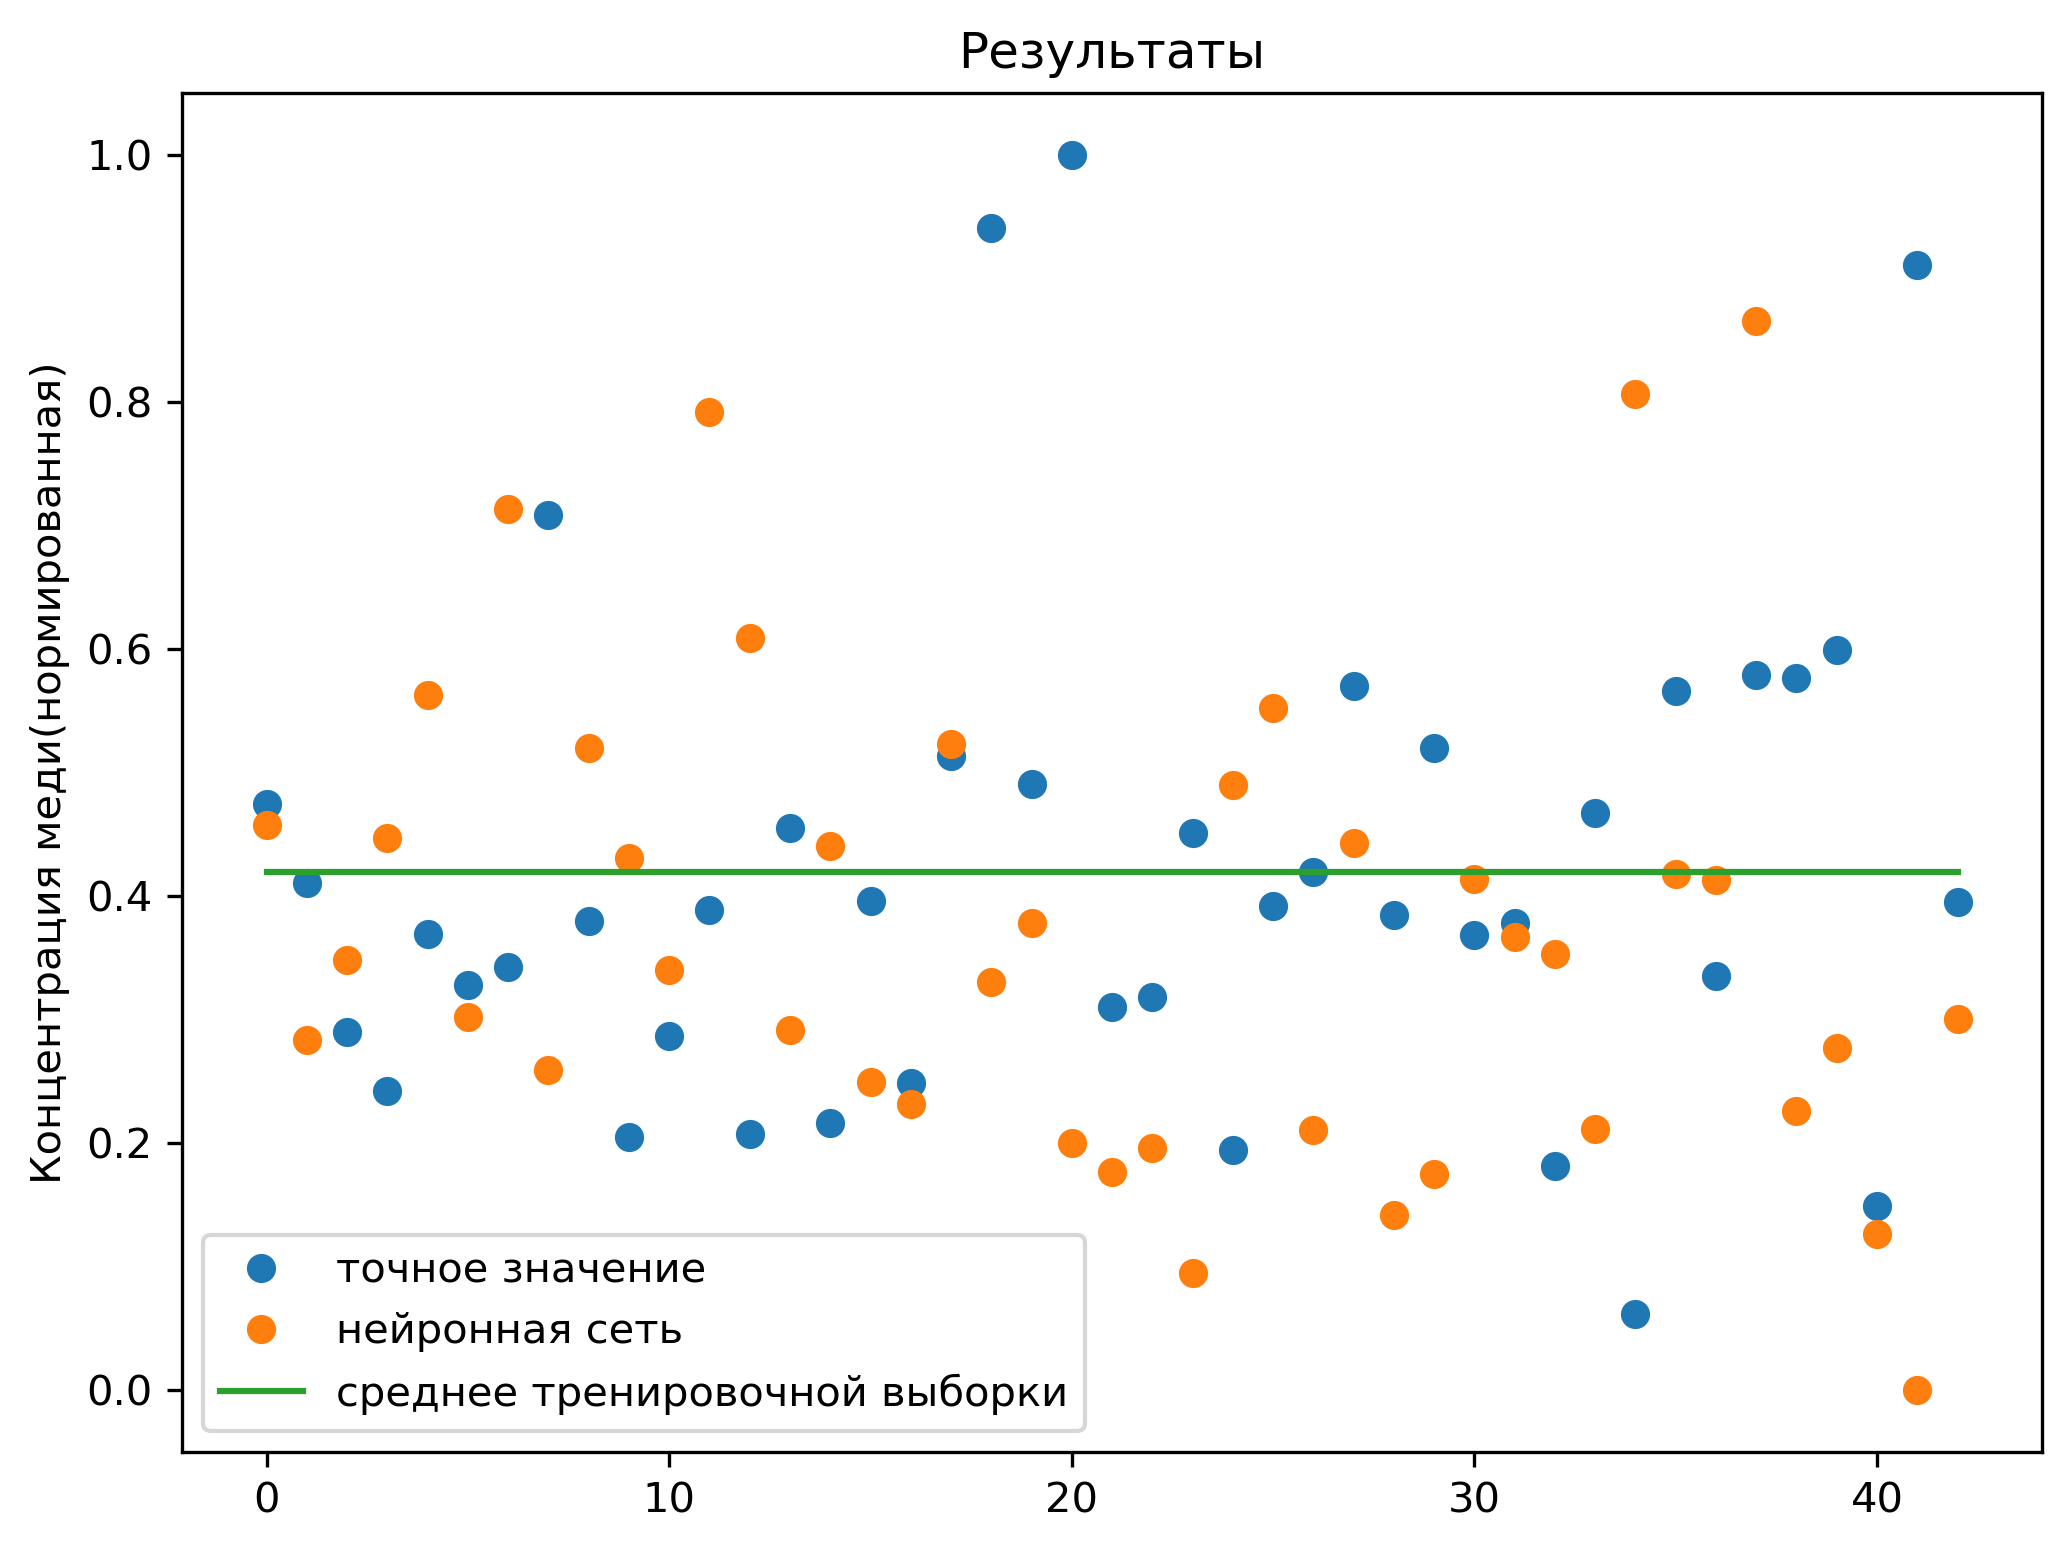

In [413]:
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300
# данные тестовой выборки и предикт
plt.plot(y_train, 'o', label="точное значение")
result = [net.feedforward(train[i][0])[0] for i in range(len(y_train))]
plt.plot(result, 'o', label="нейронная сеть")
plt.plot(y_train.mean()*np.ones(len(y_train)), label="среднее тренировочной выборки")
plt.title("Результаты")
plt.ylabel("Концентрация меди(нормированная)")
plt.legend()
plt.savefig("result")
plt.show()

In [408]:
W = pd.DataFrame()
spectrum = init_spectrum()
# W.index = list(spectrum.keys())
Ww = sum(abs(net.weights[0][i]) for i in range(N1))/N1
# print(Ww)
k = 1
weight = pd.Series(abs(net.weights[0][k])/max(abs(net.weights[0][k])), index=list(spectrum.keys()))
# weight = pd.Series(Ww, index=list(spectrum.keys()))
# W = W.append(weight, ignore_index=True)
# W = pd.concat([W, pd.Series(list(spectrum.keys()))], ignore_index=True)
W = pd.concat([W, weight])
W.round(3).T

ValueError: Length of values (5) does not match length of index (18)